In [19]:
class Module(object):
    #fonction pour passer au 'module' suivant
    def forward(self,x):
        pass
    
    def backward_updateGradient(self,x,delta):
        pass
    
    def zeroGradParameters(self):
        pass
    
    #deriver de la fonction de forward 
    def backward_delta(self,x,delta):
        pass

    
class Loss(object):
    def getLossValue (self, ypredit ,y):
        pass
    def backward(self,ypredit,y):
        pass
    
class SquareLoss(Loss) :
    def __init__(self,dimension):
        self.dimension=dimension
        
    def getLossValue (self, y_predit,y):
        loss = 0.0
        for k in range(0,self.dimension) :
            loss += (y_predit[k]-y[k])*(y_predit[k]-y[k])
        loss /= self.dimension
        return loss
    
    # renvoi la valeur de delta
    # derive du loss
    def backward(self,y_predit, y):
        grad = np.zeros(self.dimension)
        for k in range(0,self.dimension):
            grad[k] = (2*(y_predit[k]-y[k]))/self.dimension
        return grad

    
# Module lineaire    
class LinearModule(Module):
    def __init__(self,n,C):
        self.X = n #input_dimension
        self.Y = C #ouput_dimension
        self.theta = np.zeros((self.X,self.Y))
        self.grad = np.zeros((self.X,self.Y))
        
    def zeroGradParameters(self):
        self.grad = np.zeros((self.X,self.Y))
    
    # produit matriciel
    def forward(self,x):
        result = np.dot(x,self.theta)
        return result
    
    # init theta avec des varleurs aleatoire
    def randomize(self, variance):
        for i in range(0,self.X):
            for j in range(0,self.Y):
                self.theta[i][j]= random.uniform(-variance,variance)
    
    # deriver de la fonction de forward 
    def backward_updateGradient(self,x,delta):
        #print(self.X)
        #print(self.Y)
        for i in range(0,self.X):
            for j in range(0,self.Y):
                self.grad[i][j] += delta[j]*x[i]
    
    #renvoi le loss par rapport a delta
    def backward_delta(self, x , delta):    
        #grad du Loss par rapport à x. Donc de taille n
        grad_x = np.zeros(self.X)
        for i in range(0,self.X):
            for k in range(0,self.Y):
                grad_x[i] += delta[k]*self.theta[i,k]
        return grad_x
    
    def updateParameters(self,learning_rate):
        self.theta = self.theta - learning_rate*self.grad
        
        
#Module tanh      
class TanHModule(Module):
    def __init__(self,dimension):
        self.X = dimension
     
    #tanh
    def forward(self,x):
        return np.tanh(x)
    
    #(derive de tanh) * delta
    def backward_delta(self,x,delta):
        self.grad = np.multiply(delta, (1.0-np.tanh(x)**2).T)
        return self.grad
    
   # init theta avec des varleurs aleatoire
    def randomize(self, variance):
        pass
    
    
    
import numpy as np
import random
import matplotlib.pyplot as plt
from math import tanh


def load_mnist(filename):
    with open(filename,"r") as f:
        f.readline()
        data =[ [float(x) for x in l.split()] for l in f if len(l.split())>2]
    tmp = np.array(data)
    return tmp[:,1:],tmp[:,0].astype(int)

#matrices de 16*16
train = load_mnist('USPS/USPS_train.txt')
test = load_mnist('USPS/USPS_test.txt')

#donnees de train
x_train = train[0]
y_train = train[1]

#donnees de test
x_test = test[0]
y_test = test[1]


#affichge l'image
def display_image ( X ):
    """
    Etant donné un tableau X de 256 flotants représentant une image de 16x16
    pixels, la fonction affiche cette image dans une fenêtre.
    """
    # on teste que le tableau contient bien 256 valeurs
    if X.size != 256:
        raise ValueError ( "Les images doivent être de 16x16 pixels" )

    # on crée une image pour imshow: chaque pixel est un tableau à 3 valeurs
    # (1 pour chaque canal R,G,B). Ces valeurs sont entre 0 et 1
    Y = X / X.max ()
    img = np.zeros ( ( Y.size, 3 ) )
    for i in range ( 3 ):
        img[:,i] = X

    # on indique que toutes les images sont de 16x16 pixels
    img.shape = (16,16,3)

    # affichage de l'image
    plt.imshow( img )
    plt.show ()

#print(y_test[0])
#print(y_train[0])

In [20]:
m_linear1 = LinearModule(256,500)
m_tanh1 = TanHModule(500)
m_linear2 = LinearModule(500,10)
m_tanh2 = TanHModule(10)
loss = SquareLoss(10)

error = []

gradient_step = 0.1
m_linear1.randomize(1) 
m_linear2.randomize(1) 


maxEpoch = 1000

all_losses= np.zeros(maxEpoch)
all_losses_global_train=np.zeros(maxEpoch)
all_losses_global_test=np.zeros(maxEpoch)
all_out =np.zeros(maxEpoch)
accuracy_train=np.zeros(maxEpoch)
accuracy_test=np.zeros(maxEpoch)


for i in range(maxEpoch):
    j=random.randint(0,len(x_train)-1)
    x = x_train[j]
    y = y_train[j]
    Y = [-1]*10
    Y[y] = 1
    
    m_linear1.zeroGradParameters()   
    m_linear2.zeroGradParameters()
    
    prediction_linear1 = m_linear1.forward(x)
    prediction_tanh1 = m_tanh1.forward(prediction_linear1)
    prediction_linear2 = m_linear2.forward(prediction_tanh1)
    prediction_tanh2 = m_tanh2.forward(prediction_linear2)

    l = loss.getLossValue(prediction_tanh2,Y)
    error.append(l)
    delta_tanh2 = loss.backward(prediction_tanh2,Y)

    delta_linear2 = m_tanh2.backward_delta(prediction_linear2, delta_tanh2)

    m_linear2.backward_updateGradient(prediction_tanh1,delta_linear2)
    delta_tanh1 = m_linear2.backward_delta(prediction_tanh1,delta_linear2)
    
    delta_linear1 = m_tanh1.backward_delta(prediction_linear1,delta_tanh1)
    
    m_linear1.backward_updateGradient(x,delta_linear1)
    
    #mets a jour les parametre de la 1eme couche linear
    m_linear1.updateParameters(gradient_step)
    
    #mets a jour les parametre de la 2eme couche linear
    m_linear2.updateParameters(gradient_step)
    
    all_losses_global_train[i] = 0
    for k in range(0,len(x_train)):
        Y_train = [-1]*10
        Y_train[y_train[k]] = 1
        all_losses_global_train[i] += loss.getLossValue(prediction_tanh2,Y_train)/len(x_train)
    
    all_losses_global_test[i] = 0
    for k in range(0,len(x_test)):
        Y_test = [-1]*10
        Y_test[y_test[k]] = 1
        all_losses_global_test[i] += loss.getLossValue(prediction_tanh2,Y_test)/len(x_test)
    

#plt.xlabel('iterations')  
#plt.ylabel('loss')
#plt.plot(range(maxEpoch), error)
#plt.show()


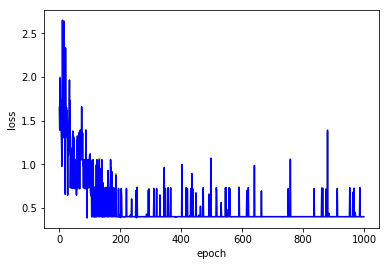

In [21]:
plt.ylabel('loss')
plt.xlabel('epoch')
#print(all_losses_global_test)
#print(all_losses_global_train)

#trace les courbes de loss pour train et test
plt.plot(all_losses_global_train,'y')
plt.plot(all_losses_global_test,'b')
plt.show()